## Нейросети - сверточные сети.
### Ноутбук составлен по воспоминаниям из разных курсов, в первую очередь Stanford cs231n, Jeremy Howard Fast AI, а также по материалам сайта https://www.jefkine.com/general/2016/09/05/backpropagation-in-convolutional-neural-networks/

In [1]:
import numpy as np
import math
import random

In [2]:
def pad_with_zeros(X):
    if len(X.shape) == 2:
        X_pad = np.zeros((X.shape[0] + 2, X.shape[1] + 2))
        X_pad[1:-1,1:-1] = X
        return X_pad
    elif len(X.shape) == 3:
        result = []
        for img in X:
            img_pad = np.zeros((img.shape[0] + 2, img.shape[1] + 2))
            img_pad[1:-1,1:-1] = img
            result.append(img_pad)
        return np.array(result)
    else:
        print("Only (H x W) and (Batch x H x W) shapes are supported")
        return None

In [3]:
pict = np.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]])

In [4]:
pad_with_zeros(pict)

array([[0., 0., 0., 0., 0.],
       [0., 1., 2., 3., 0.],
       [0., 4., 5., 6., 0.],
       [0., 7., 8., 9., 0.],
       [0., 0., 0., 0., 0.]])

In [5]:
batch = []
for i in range(8):
    batch.append(pict)
batch_padded = pad_with_zeros(np.array(batch))

In [6]:
batch_padded.shape

(8, 5, 5)

In [7]:
batch_padded[0]

array([[0., 0., 0., 0., 0.],
       [0., 1., 2., 3., 0.],
       [0., 4., 5., 6., 0.],
       [0., 7., 8., 9., 0.],
       [0., 0., 0., 0., 0.]])

In [8]:
X = np.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]])

In [9]:
K = np.array([[0.0, 1.0], [2.0, 3.0]])

In [10]:
def conv2d(X, K, pad = False):
    if pad:
        X = pad_with_zeros(X)
        
    h, w = X.shape[0], X.shape[1]
    k1, k2 = K.shape[0], K.shape[1]
    result = np.zeros((h - k1 + 1, w - k2 + 1))
    
    for i in range(0 + k1 - 1, result.shape[0] + k1 - 1):
        for j in range(0 + k2 - 1, result.shape[1] + k2 - 1):
            result[i - k1 + 1, j - k2 + 1] = (X[i - k1 + 1: i + 1, j - k2 + 1: j + 1] * K).sum()
    return result

In [11]:
conv2d(X, K)

array([[25., 31.],
       [43., 49.]])

In [12]:
conv2d(X, K, pad = True)

array([[ 3.,  8., 13.,  6.],
       [13., 25., 31., 12.],
       [25., 43., 49., 18.],
       [ 7.,  8.,  9.,  0.]])

Попробуем сначала простой слой с одним фильтром - 1 канал на входе, 1 на выходе

In [13]:
def rot180(X):
    return np.rot90(np.rot90(X))

In [14]:
class ConvLayer:
    
    def __init__(self, kernel_size = 3, pad = False):
        self.kernel = np.random.default_rng().uniform(-1, 1, (kernel_size, kernel_size)).astype(np.float32)
        self.pad = pad
        self.X_ = None
        
    def forward(self, X):
        if len(X.shape) == 2:
            if self.pad: 
                X = pad_with_zeros(X)
            self.X_ = X
            return conv2d(X, self.kernel)
        
        elif len(X.shape) == 3:
            if self.pad: 
                X = pad_with_zeros(X)
            self.X_ = X
            result = []
            for img in X:
                result.append(conv2d(img, self.kernel))
            return np.array(result)
                    
        else:
            print("Only (H x W) and (Batch x H x W) shapes are supported")
            return None
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0):
        if len(upstr_grad.shape) == 2:
            # расчет градиентов по весам фильтра
            grad_w = conv2d(self.X_, rot180(upstr_grad))
            if debug == 1: print(f'grad_w = {grad_w}')

            # расчет градиентов по входам
            for i in range(self.X_.shape[0] - self.kernel.shape[0] - self.pad):
                upstr_grad = pad_with_zeros(upstr_grad)
            grad_x = conv2d(upstr_grad, rot180(self.kernel))
            if debug > 1: print(f'grad_x = {grad_x}')

            self.kernel += -1 * grad_w * lr # домножаем на -1, так как градиентный шаг выполняется в направлении антиградиента
            return grad_x
        
        elif len(upstr_grad.shape) == 3:
            # расчет градиентов по весам фильтра
            grad_w_batch = []
            for i in range(upstr_grad.shape[0]):
                grad_w = conv2d(self.X_[i], rot180(upstr_grad[i]))
                grad_w_batch.append(grad_w)
            grad_w_batch = np.array(grad_w_batch)
            if debug == 1: print(f'grad_w_batch = {grad_w_batch}')
            
             # расчет градиентов по входам
            grad_x_batch = []
            for i in range(upstr_grad.shape[0]):
                ug = upstr_grad[i]
                for j in range(self.X_.shape[-1] - self.kernel.shape[0] - self.pad):
                    ug = pad_with_zeros(ug)
                    grad_x = conv2d(ug, rot180(self.kernel))
                    grad_x_batch.append(grad_x)
            grad_x_batch = np.array(grad_x_batch)
            if debug > 1: print(f'grad_x_batch = {grad_x_batch}')
            return grad_x_batch
            
            self.kernel += -1 * grad_w_batch.mean(axis = 0) * lr # домножаем на -1, так как градиентный шаг выполняется в направлении антиградиента
        
        else:
            print("Only (H x W) and (Batch x H x W) shapes are supported")
            return None

In [15]:
CL = ConvLayer(kernel_size = 2)

In [16]:
CL.forward(X)

array([[-2.81983447, -4.46889243],
       [-7.76700833, -9.41606629]])

In [17]:
upstr_grad = np.array([[0, 1], [2, 1]])

In [18]:
CL.backward(upstr_grad, debug = 1)

grad_w = [[ 9. 13.]
 [21. 25.]]


array([[ 0.        , -0.81612563, -0.42822608],
       [-1.63225126, -2.54885232,  0.0433422 ],
       [-1.75254905,  0.06686205,  0.47156829]])

In [19]:
X_batch = []
for i in range(5):
    X_batch.append(X)
X_batch = np.array(X_batch)
X_batch.shape

(5, 3, 3)

In [20]:
fwres = CL.forward(X_batch)
fwres

array([[[ -5.25983441,  -7.58889234],
        [-12.2470082 , -14.57606614]],

       [[ -5.25983441,  -7.58889234],
        [-12.2470082 , -14.57606614]],

       [[ -5.25983441,  -7.58889234],
        [-12.2470082 , -14.57606614]],

       [[ -5.25983441,  -7.58889234],
        [-12.2470082 , -14.57606614]],

       [[ -5.25983441,  -7.58889234],
        [-12.2470082 , -14.57606614]]])

In [21]:
upstr_grad = np.array([[[1, 1], [1, 1]],
                       [[1, 1], [1, 1]],
                       [[1, 1], [1, 1]],
                       [[1, 1], [1, 1]],
                       [[1, 1], [1, 1]]])

In [22]:
CL.backward(upstr_grad, debug = 1)

grad_w_batch = [[[12. 16.]
  [24. 28.]]

 [[12. 16.]
  [24. 28.]]

 [[12. 16.]
  [24. 28.]]

 [[12. 16.]
  [24. 28.]]

 [[12. 16.]
  [24. 28.]]]


array([[[-0.90612561, -1.46435171, -0.55822611],
        [-1.99240011, -2.32905793, -0.33665782],
        [-1.0862745 , -0.86470622,  0.22156829]],

       [[-0.90612561, -1.46435171, -0.55822611],
        [-1.99240011, -2.32905793, -0.33665782],
        [-1.0862745 , -0.86470622,  0.22156829]],

       [[-0.90612561, -1.46435171, -0.55822611],
        [-1.99240011, -2.32905793, -0.33665782],
        [-1.0862745 , -0.86470622,  0.22156829]],

       [[-0.90612561, -1.46435171, -0.55822611],
        [-1.99240011, -2.32905793, -0.33665782],
        [-1.0862745 , -0.86470622,  0.22156829]],

       [[-0.90612561, -1.46435171, -0.55822611],
        [-1.99240011, -2.32905793, -0.33665782],
        [-1.0862745 , -0.86470622,  0.22156829]]])

Без padding ответ верный, попробуем с padding

In [23]:
CL = ConvLayer(kernel_size = 3, pad = True)

In [24]:
CL.forward(X)

array([[ 3.14959064,  2.9768759 ,  0.06405234],
       [ 2.76574048,  2.2184574 , -1.63545141],
       [-5.85942543, -4.6367906 , -6.81999871]])

In [25]:
upstr_grad = np.array([[0, 1, 2], [1, 2, 3], [2, 3, 0]])

In [26]:
CL.backward(upstr_grad, debug = 1)

grad_w = [[ 8. 23. 28.]
 [27. 62. 61.]
 [44. 73. 60.]]


array([[-0.24945214, -1.71793833, -3.15624186],
       [-1.3923476 , -1.71854439, -2.11779997],
       [-0.32351297, -1.14102778,  3.4653154 ]])

In [27]:
CL.forward(X_batch)

array([[[ -4.61040935,  -9.37312408,  -8.91594768],
        [-13.46425945, -21.32154247, -17.64545143],
        [-17.39942527, -20.12679043, -16.33999872]],

       [[ -4.61040935,  -9.37312408,  -8.91594768],
        [-13.46425945, -21.32154247, -17.64545143],
        [-17.39942527, -20.12679043, -16.33999872]],

       [[ -4.61040935,  -9.37312408,  -8.91594768],
        [-13.46425945, -21.32154247, -17.64545143],
        [-17.39942527, -20.12679043, -16.33999872]],

       [[ -4.61040935,  -9.37312408,  -8.91594768],
        [-13.46425945, -21.32154247, -17.64545143],
        [-17.39942527, -20.12679043, -16.33999872]],

       [[ -4.61040935,  -9.37312408,  -8.91594768],
        [-13.46425945, -21.32154247, -17.64545143],
        [-17.39942527, -20.12679043, -16.33999872]]])

In [28]:
upstr_grad = np.array([[[1, 1, 1], [1, 1, 1], [1, 1, 1]],
                       [[1, 1, 1], [1, 1, 1], [1, 1, 1]],
                       [[1, 1, 1], [1, 1, 1], [1, 1, 1]],
                       [[1, 1, 1], [1, 1, 1], [1, 1, 1]],
                       [[1, 1, 1], [1, 1, 1], [1, 1, 1]]])

In [29]:
CL.backward(upstr_grad, debug = 1)

grad_w_batch = [[[12. 21. 16.]
  [27. 45. 33.]
  [24. 39. 28.]]

 [[12. 21. 16.]
  [27. 45. 33.]
  [24. 39. 28.]]

 [[12. 21. 16.]
  [27. 45. 33.]
  [24. 39. 28.]]

 [[12. 21. 16.]
  [27. 45. 33.]
  [24. 39. 28.]]

 [[12. 21. 16.]
  [27. 45. 33.]
  [24. 39. 28.]]]


array([[[-2.09502394, -3.03304642, -2.92647658],
        [-3.01484573, -4.35544471, -3.56100336],
        [-2.21196342, -2.69910018, -2.21969226]],

       [[-2.09502394, -3.03304642, -2.92647658],
        [-3.01484573, -4.35544471, -3.56100336],
        [-2.21196342, -2.69910018, -2.21969226]],

       [[-2.09502394, -3.03304642, -2.92647658],
        [-3.01484573, -4.35544471, -3.56100336],
        [-2.21196342, -2.69910018, -2.21969226]],

       [[-2.09502394, -3.03304642, -2.92647658],
        [-3.01484573, -4.35544471, -3.56100336],
        [-2.21196342, -2.69910018, -2.21969226]],

       [[-2.09502394, -3.03304642, -2.92647658],
        [-3.01484573, -4.35544471, -3.56100336],
        [-2.21196342, -2.69910018, -2.21969226]]])

С padding тоже верно

Попробуем построить сверточную нейросеть с одним фильтром для работы с MNIST. Возьмем реализации требуемых классов из предыдущего ноутбука

In [19]:
class Network:
    """Реализация нейросети с методом predict, чтобы экземпляры класса можно было использовать в plot_decision_regions.
    
    
    Параметры инициализатора:
    layers -- список экземпляров классов слоев нейросети
    
    Параметры forward():
    X -- матрица размерности (N, D), где N - размер batch, D - количество признаков экземпляра выборки
    
    Парметры backward():
    upstr_grad -- входящие градиенты со следующего уровня
    lr -- learning rate
    debug -- уровень логгирования.
    """
    
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0):
        for layer in reversed(self.layers):
            upstr_grad = layer.backward(upstr_grad, lr = lr, debug = debug)
        return upstr_grad
    
    def predict(self, X):
        Y_hat = np.round(self.forward(X))
        return Y_hat

In [18]:
class Linear:
    """Fully Connected Layer. 
    
    
    Параметры инициализатора:
    inp -- количество входящих нейронов
    out -- количество исходящих нейронов
    
    Инициализация весов подсмотрена в pytorch
    
    Параметры forward():
    X -- матрица размерности (N, inp), где N - размер batch
    
    Парметры backward():
    upstr_grad -- входящие градиенты со следующего уровня
    lr -- learning rate
    debug -- уровень логгирования. Выставление debug == 2 приведет к выводу градиентов на каждом шаге обучения
    """
    
    def __init__(self, inp, out):
        self.inp = inp
        self.out = out
        stdv = 1.0 / np.sqrt(inp)
        self.W = np.random.default_rng().uniform(-stdv, stdv, (inp, out)).astype(np.float32)
        self.X_ = None # кэш для хранения входов с предыдущего уровня для расчета градиентов на backward pass
        
    def forward(self, X):
        self.X_ = X.astype(np.float32)
        return np.dot(X.astype(np.float32), self.W)
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0): 
        # реализация, не учитывающая, что с ростом batch_size градиенты будут расти пропорционально
        # delta_W = np.dot(np.transpose(self.X_), upstr_grad.astype(np.float32))
        
        # градиенты усредняются по batch size, чтобы рост batch_size не приводил к пропорциональному росту градиентов
        delta_W = np.dot(np.transpose(self.X_), upstr_grad.astype(np.float32)) / self.X_.shape[0]
        
        self.W += (-1) * lr * delta_W # домножаем на -1, так как необходимо идти в противоположную от градиента сторону
        if debug == 2: print(f'Linear Layer: W gradients = {delta_W}')
        if debug == 2: print(f'Linear Layer: new weights = {self.W}')
        return np.dot(upstr_grad.astype(np.float32), np.transpose(self.W))

In [20]:
class Relu:
    """Rectified Linear Unit
    
    Параметры lr и debug - заглушки, чтобы из класса Network можно было циклически вызывать backward для 
    всех слоев с одним и тем же набором параметров. 
    """
    
    def __init__(self):
        self.X_ = None
    
    def forward(self, X):
        self.X_ = X
        return np.where(X <= 0, 0, X)
    
    def backward(self, upstr_grad, lr = None, debug = 0):
        return upstr_grad * np.where(self.X_ <= 0, 0, 1)

In [21]:
def CELoss(Y_true, Y_hat):
    """ Функция потерь Перекрестная кросс-энтропия (Cross-Entropy Loss)
    
    
    Параметры:
    Y_true -- ответы обучающей выборки. Матрица размерностью (N, T), где N - размер batch, T - количество классов в датасете, значения 0 или 1
    Y_hat -- ответы модели. Матрица размерностью (N, T), где N - размер batch, T - количество классов в датасете.
    Значения - вероятности классов в интервале [0, 1]
    
    Возвращает усредненное по batch значение потерь, а также матрицу градиентов размерностью (N, T) для использования в backpropagation
    
    """
    
    eps = 1e-10
    Y_loss = -np.log2(Y_hat + eps)
    Y_grad = -1 / (np.log(2) * Y_hat + eps)
    loss = Y_loss * Y_true
    grad = Y_grad * Y_true
    return loss.sum(), grad

In [22]:
def create_sm_jacobian(sm_out):
    """ Фуункция расчета якобиана для Softmax
    
    
    Параметры:
    
    sm_out -- сохраненный на этапе forward pass выход из слоя Softmax. Вектор размерности (количество классов, 1)
    Если через Softmax проходил batch размером (N x количество классов), каждая строка этой матрицы должна подаваться на вход функции отдельно
    
    Возвращает якобиан размерности (количество классов x количество классов)
    """
    
    
    jac = np.zeros((sm_out.shape[0], sm_out.shape[0]))
    for i in range(sm_out.shape[0]):
        for j in range(sm_out.shape[0]):
            if i == j:
                jac[i, j] = sm_out[i] * (1 - sm_out[i])
            else:
                jac[i, j] = -1 * sm_out[i] * sm_out[j]
    return jac

In [23]:
class Softmax:
    """ Слой Softmax
    Реализация написана для batch_size >= 2
    
    На основе сохраненных на forward pass значений выходов формирует на backward pass якобианы частных производных выходов по входам с помощью create_sm_jacobian(). 
    Так как N таких якобианов формируют матрицу размером N x количество классов x количество классов, 
    скалярное произведение такой матрицы на входящие градиенты может быть получено только попарно - одна строка входящего градиента на 
    один якобиан.
    """
    
    
    def __init__(self):
        self.out = None
        
    def forward(self, X):
        exps = np.exp(X)
        sum_col = np.reshape(np.sum(exps, axis = 1), (-1, 1))
        sums = sum_col
        for i in range(X.shape[1] - 1):
            sums = np.concatenate((sums, sum_col), axis = 1)
        self.out = exps / sums
        return self.out
    
    def backward(self, upstream_grad, lr = None, debug = 0):
        gradients = np.array([])
        for ug, sm_out in zip(upstream_grad, self.out):
            SMJ = create_sm_jacobian(sm_out)
            grad = np.dot(ug, SMJ)
            gradients = np.append(gradients, grad)
        return np.reshape(gradients, (upstream_grad.shape[0], -1))

In [54]:
class Flatten():
    
    def __init__(self):
        self.input_dims = None
        
    def forward(self, X):
        self.input_dims = X.shape
        return X.flatten()
    
    def backward(self, upstr_grad, lr = None, debug = 0):
        return np.reshape(upstr_grad, self.input_dims)

In [24]:
class Network_multiclass:
    
    """Аналогичен классу Network, но метод predict переписан с учетом наличия Softmax на выходе из нейросети"""
    
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0):
        for layer in reversed(self.layers):
            upstr_grad = layer.backward(upstr_grad, lr = lr, debug = debug)
        return upstr_grad
    
    def predict(self, X):
        Y_hat = self.forward(X).argmax(axis = 1)
        return Y_hat

In [25]:
def one_hot_enc(vec, num_classes):
    
    """Преобразует вектор скаляров - номеров классов в матрицу one-hot-encoded векторов"""
    
    assert len(vec.shape) == 2 and vec.shape[1] == 1, 'only [N x 1] vectors are supported'
    
    result = np.zeros((vec.shape[0], num_classes))
    np.put_along_axis(result, vec, 1, axis = 1)
    return result

In [85]:
def train_network_conv(Net, X_train, Y_train, batch_size = 1, lr = 1, max_iter = 50, debug = 0):
    
    """Функция аналогична train_network(), но переписана с учетом Softmax на выходе из сети. Используется функция потерь CELoss,
    также ввиду векторного вида ответов изменен метод расчета accuracy"""
    
    loss = 1e3
    iteration = 0
    Y_train_enc = one_hot_enc(np.reshape(Y_train, (-1, 1)), 10)
    
    while loss > 0.01 and iteration < max_iter:
        
        period = math.ceil(max_iter / 30)
        # if debug and iteration % period == 0: print(f'iteration {iteration}, loss = {loss}, accuracy = {acc}')
        if debug and iteration % period == 0: print(f'iteration {iteration}, loss = {loss}, accuracy = {0}')
        
        batch_index = random.sample([i for i in range(len(X_train))], batch_size)
        Y_hat = Net.forward(X_train[batch_index])
        batch_loss, grad = CELoss(Y_train_enc[batch_index], Y_hat)
        Net.backward(grad, lr = lr, debug = debug)
        iteration += 1

In [65]:
from sklearn.datasets import load_digits
digits = load_digits()

In [66]:
digits.data.shape

(1797, 64)

In [67]:
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [68]:
digits.target[0]

0

<Figure size 432x288 with 0 Axes>

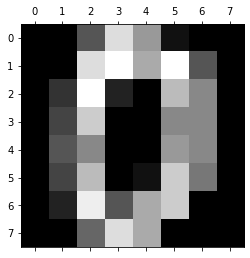

In [69]:
import matplotlib.pyplot as plt
plt.gray()
plt.matshow(digits.images[0])
plt.show()

Нормализуем данные

In [70]:
X, Y = digits.data, digits.target

In [71]:
X = X / np.max(X)

In [75]:
X.shape

(1797, 64)

In [76]:
X = np.reshape(X, (1797, 8, 8))

In [77]:
X.shape

(1797, 8, 8)

In [72]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=100, random_state = 42)

In [88]:
NNM = Network_multiclass([ConvLayer(pad = True), Relu(), ConvLayer(pad = True), Relu(), ConvLayer(pad = True), Relu(), Flatten(),
                          Linear(64, 30), Relu(), Linear(30, 10), Softmax()])
train_network_conv(NNM, train_X, train_Y, lr = 0.03, max_iter = 500, debug = 1)

iteration 0, loss = 1000.0, accuracy = 0


AxisError: axis 1 is out of bounds for array of dimension 1